In [2]:
import math
from os import listdir
import matplotlib.pyplot as plt
plt.ion()

def load_images(IMG_DIR):
    images = []
    for image_path in listdir(IMG_DIR):
        if image_path == '.DS_Store':
            continue
        img = cv2.cvtColor(cv2.imread(IMG_DIR + image_path), cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

def show_images(images, make_random=False, fig_title='Default title', CMAP=None):
    count = len(images)
    col_count = 5
    rows = math.ceil(float(len(images)) / float(col_count))
    fig = plt.figure(figsize=(4*int(col_count),2*rows))
    fig.suptitle(fig_title, fontsize=16)
    
    for i in range(count):
        image = images[i]
        ax1 = fig.add_subplot(rows,col_count,i+1)
        #ax1.set_title(labels[i] + ' occurences', fontsize=8)
        ax1.imshow(image, cmap=CMAP)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

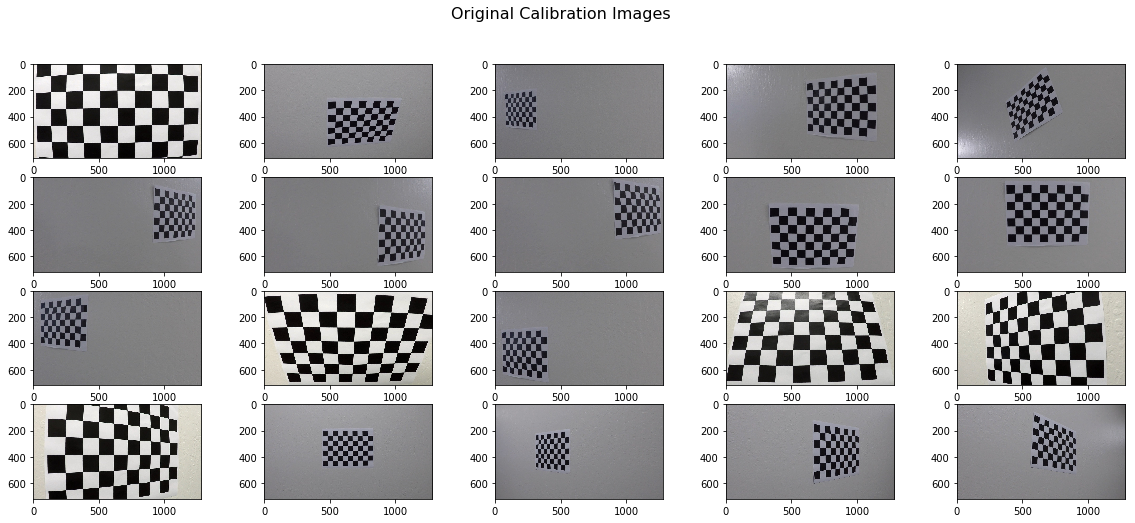

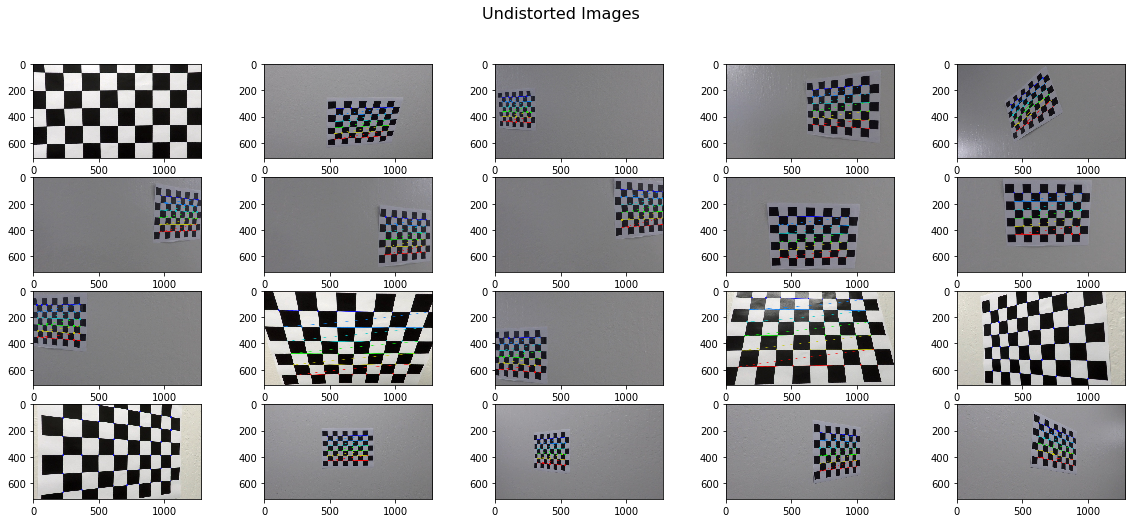

In [3]:
import cv2
import numpy as np

# Camera calibration
OBJ_POINTS = np.zeros((6*9, 3), np.float32)
OBJ_POINTS[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates
def calibrate_camera(images):
    imgpoints = []
    objpoints = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        image = cv2.drawChessboardCorners(image, (9,6), corners, ret)
        
        if (ret == True):
            imgpoints.append(corners)
            objpoints.append(OBJ_POINTS)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return (mtx, dist)

def undistort_image(image, mtx, dist, original_image = None):
    return cv2.undistort(image, mtx, dist, None, mtx)

calibration_images = load_images('./camera_cal/')
show_images(calibration_images, fig_title='Original Calibration Images')

undistorted_images = []
(MTX, DIST) = calibrate_camera(calibration_images)
for image in calibration_images:
    undistorted_images.append(undistort_image(image, MTX, DIST))
show_images(undistorted_images, fig_title='Undistorted Images')

In [4]:
# Transform color and gradient
# TODO(saajan): See if this needs improvement
def transform_sobel_s_(image, s_thresh=(90, 255), sx_thresh=(15, 100), original_image = None):
    image = np.copy(image)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

In [5]:
# Perspective transform

SRC = np.float32([[590, 460], [330, 670], [1060, 670], [700, 460]])
DST = np.float32([[330, 0], [330, 670], [1060, 670], [1060, 0]])
M = cv2.getPerspectiveTransform(SRC, DST)
M_inverse = cv2.getPerspectiveTransform(DST, SRC)
def transform_perspective(image, original_image = None):
    [y_orig, x_orig] = image.shape[:2]
    warped = cv2.warpPerspective(image, M, (x_orig, y_orig), flags=cv2.INTER_LINEAR)
#     # Testing by drawing a rectangle
#     image = cv2.polylines(image, np.int32([SRC.reshape((-1,1,2))]), True, (0,255,255))
#     show_images([image], fig_title='Rect Image')
    return warped

def transform_perspective_reverse(image, original_image = None):
    [y_orig, x_orig] = image.shape[:2]
    warped = cv2.warpPerspective(image, M_inverse, (x_orig, y_orig), flags=cv2.INTER_LINEAR)
    return warped

In [24]:
from moviepy.video.io.bindings import mplfig_to_npimage

# Locate lane lines
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

LEFT_FIT = None
RIGHT_FIT = None
LEFT_FIT_CR = None
RIGHT_FIT_CR = None
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
def locate_lane_lines(image, original_image = None):
    global LEFT_FIT
    global RIGHT_FIT
    global ym_per_pix
    global xm_per_pix
    global LEFT_FIT_CR
    global RIGHT_FIT_CR
    
    out_img = np.dstack((image, image, image))*255
    window_img = np.zeros_like(out_img)
        
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    nonzero_img_mask = np.zeros_like(image)
    nonzero_img_mask[nonzeroy, nonzerox] = 1

    # Set the width of the windows +/- margin
    margin = 175
    # Set minimum number of pixels required to recenter window
    minpix = 50
    # Set minimum number of pixels required to reconsider last image's fits
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Evaluate if the last fit can be used
    if(LEFT_FIT is not None and RIGHT_FIT is not None):
        left_lane_inds_temp = ((nonzerox > (LEFT_FIT[0]*(nonzeroy**2) + LEFT_FIT[1]*nonzeroy + LEFT_FIT[2] - margin)) & (nonzerox < (LEFT_FIT[0]*(nonzeroy**2) + LEFT_FIT[1]*nonzeroy + LEFT_FIT[2] + margin))) 
        right_lane_inds_temp = ((nonzerox > (RIGHT_FIT[0]*(nonzeroy**2) + RIGHT_FIT[1]*nonzeroy + RIGHT_FIT[2] - margin)) & (nonzerox < (RIGHT_FIT[0]*(nonzeroy**2) + RIGHT_FIT[1]*nonzeroy + RIGHT_FIT[2] + margin)))  
        # Again, extract left and right line pixel positions
        leftx_temp = nonzerox[left_lane_inds_temp]
        rightx_temp = nonzerox[right_lane_inds_temp]
        
        print(str(len(leftx_temp)) + " " + str(len(rightx_temp)) + " " + str(len(leftx_temp) + len(rightx_temp)))
        
        total_pix = len(leftx_temp) + len(rightx_temp)
        else if (total_pix > 35000 and total_pix < 65000):
            LEFT_FIT = None
            RIGHT_FIT = None
            LEFT_FIT_CR = None
            RIGHT_FIT_CR = None
        
    if((LEFT_FIT is None or RIGHT_FIT is None) or should_recompute == True):
        # window settings
        window_width = 50 
        window_height = 80 # Break image into 9 vertical layers since image height is 720
        
        window_centroids = find_window_centroids(image, window_width, window_height, margin)

        left_img_mask = np.zeros_like(image)
        right_img_mask = np.zeros_like(image)
        # If we found any window centers
        if len(window_centroids) > 0:
            # Go through each level and draw the windows     
            for level in range(0,len(window_centroids)):
                # Window_mask is a function to draw window areas
                l_mask = window_mask(window_width,window_height,image,window_centroids[level][0],level)
                r_mask = window_mask(window_width,window_height,image,window_centroids[level][1],level)
                
                # Accumulate window areas
                left_img_mask = left_img_mask | l_mask
                right_img_mask = right_img_mask | r_mask
         
        # Final non-zero pixels in window areas    
        left_img_mask = left_img_mask & nonzero_img_mask
        right_img_mask = right_img_mask & nonzero_img_mask
        
        nonzero_left = left_img_mask.nonzero()
        nonzero_right = right_img_mask.nonzero()
        
        # Fit a second order polynomial to each
        LEFT_FIT = np.polyfit(nonzero_left[0], nonzero_left[1], 2)
        RIGHT_FIT = np.polyfit(nonzero_right[0], nonzero_right[1], 2)
        
        LEFT_FIT_CR = np.polyfit(nonzero_left[0]*ym_per_pix, nonzero_left[1]*xm_per_pix, 2)
        RIGHT_FIT_CR = np.polyfit(nonzero_right[0]*ym_per_pix, nonzero_right[1]*xm_per_pix, 2)
            
    if(LEFT_FIT is None or RIGHT_FIT is None):
        return image
    else:
        # Visualizing
        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        y_eval = np.max(ploty)
        left_fitx = LEFT_FIT[0]*ploty**2 + LEFT_FIT[1]*ploty + LEFT_FIT[2]
        right_fitx = RIGHT_FIT[0]*ploty**2 + RIGHT_FIT[1]*ploty + RIGHT_FIT[2]
        
        points_left = np.array([[[xi, yi]] for xi, yi in zip(left_fitx, ploty)]).astype(np.int32)
        points_right = np.array([[[xi, yi]] for xi, yi in zip(right_fitx, ploty)]).astype(np.int32)
        points_right = np.flipud(points_right)
        lane_fill_points = np.concatenate((points_left, points_right))
        cv2.fillPoly(window_img, [lane_fill_points], (0,255, 0))
        
        # Calculate vehicle offset
        centre_of_image = image.shape[1]/2
        centre_of_car = left_fitx[len(left_fitx)-1] + np.abs(right_fitx[len(right_fitx)-1] - left_fitx[len(left_fitx)-1])/2.0;
        offset = (centre_of_image - centre_of_car) * xm_per_pix
        offset_str = 'Vehicle is ' + str("{0:.2f}".format(np.abs(offset))) + ' m ' + str('left of center' if (offset < 0.0) else 'right of center')
        
        # Reverse perspective
        reverse_transformed_mask = transform_perspective_reverse(window_img)
        #reverse_transformed_mask = np.dstack((reverse_transformed_mask, reverse_transformed_mask, reverse_transformed_mask))*255
        result = cv2.addWeighted(original_image, 1, reverse_transformed_mask, 0.3, 0) 
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*LEFT_FIT_CR[0]*y_eval*ym_per_pix + LEFT_FIT_CR[1])**2)**1.5) / np.absolute(2*LEFT_FIT_CR[0])
        right_curverad = ((1 + (2*RIGHT_FIT_CR[0]*y_eval*ym_per_pix + RIGHT_FIT_CR[1])**2)**1.5) / np.absolute(2*RIGHT_FIT_CR[0])
        # Now our radius of curvature is in meters
        #print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m
        
        #cv2.putText(result,"Radius of curvature: " + left_curverad + " | " + right_curverad, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
        cv2.putText(result, "Radius of curvature: " + str("{0:.2f}".format(left_curverad)) + "m | "\
            + str("{0:.2f}".format(right_curverad)) + "m", (int(50), int(50)), cv2.FONT_HERSHEY_PLAIN,\
            3, (255,255,255), 7, cv2.LINE_AA)
            #, size, color, thickness)
        cv2.putText(result, offset_str, (int(50), int(100)), cv2.FONT_HERSHEY_PLAIN,\
            3, (255,255,255), 7, cv2.LINE_AA)
        
        
        return result

In [25]:
# Window 1 approach

# LEFT_FIT = None
# RIGHT_FIT = None
# def locate_lane_lines(image):
#     global LEFT_FIT
#     global RIGHT_FIT
    
#     out_img = np.dstack((image, image, image))*255
#     window_img = np.zeros_like(out_img)
        
#     # Identify the x and y positions of all nonzero pixels in the image
#     nonzero = image.nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])

#     # Set the width of the windows +/- margin
#     margin = 150
#     # Set minimum number of pixels required to recenter window
#     minpix = 50
#     # Set minimum number of pixels required to reconsider last image's fits
#     # TODO(saajan): Rethink the value of this param
#     min_pix_full_image = 50000
    
#     # Create empty lists to receive left and right lane pixel indices
#     left_lane_inds = []
#     right_lane_inds = []
    
#     # Evaluate if the last fit can be used
#     if(LEFT_FIT is not None and RIGHT_FIT is not None):
#         left_lane_inds_temp = ((nonzerox > (LEFT_FIT[0]*(nonzeroy**2) + LEFT_FIT[1]*nonzeroy + LEFT_FIT[2] - margin)) & (nonzerox < (LEFT_FIT[0]*(nonzeroy**2) + LEFT_FIT[1]*nonzeroy + LEFT_FIT[2] + margin))) 
#         right_lane_inds_temp = ((nonzerox > (RIGHT_FIT[0]*(nonzeroy**2) + RIGHT_FIT[1]*nonzeroy + RIGHT_FIT[2] - margin)) & (nonzerox < (RIGHT_FIT[0]*(nonzeroy**2) + RIGHT_FIT[1]*nonzeroy + RIGHT_FIT[2] + margin)))  
#         # Again, extract left and right line pixel positions
#         leftx_temp = nonzerox[left_lane_inds_temp]
#         rightx_temp = nonzerox[right_lane_inds_temp]
        
#         if (len(leftx_temp) + len(rightx_temp) < min_pix_full_image):
#             LEFT_FIT = None
#             RIGHT_FIT = None
        
#     if(LEFT_FIT is None and RIGHT_FIT is None):
#         # window settings
#         window_width = 50 
#         window_height = 80 # Break image into 9 vertical layers since image height is 720
#         margin = 100 # How much to slide left and right for searching
        
#         window_centroids = find_window_centroids(image, window_width, window_height, margin)
        
#         left_fit_image = 
#         # If we found any window centers
#         if len(window_centroids) > 0:

#             # Points used to draw all the left and right windows
#             l_points = np.zeros_like(image)
#             r_points = np.zeros_like(image)

#             # Go through each level and draw the windows 	
#             for level in range(0,len(window_centroids)):
#                 # Window_mask is a function to draw window areas
#                 l_mask = window_mask(window_width,window_height,image,window_centroids[level][0],level)
#                 r_mask = window_mask(window_width,window_height,image,window_centroids[level][1],level)
                
                

                
#         # If no window centers found, just display orginal road image
#         else:
#             output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        
        
        
        
        
#         # Take a histogram of the bottom half of the image
#         histogram = np.sum(image[image.shape[0]//2:,:], axis=0)

#         # Find the peak of the left and right halves of the histogram
#         # These will be the starting point for the left and right lines
#         midpoint = np.int(histogram.shape[0]/2)
#         leftx_base = np.argmax(histogram[:midpoint])
#         rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#         # Choose the number of sliding windows
#         nwindows = 9
#         # Set height of windows
#         window_height = np.int(image.shape[0]/nwindows)
        
#         # Current positions to be updated for each window
#         leftx_current = leftx_base
#         rightx_current = rightx_base
        
#         for window in range(nwindows):
#             # Identify window boundaries in x and y (and right and left)
#             win_y_low = image.shape[0] - (window+1)*window_height
#             win_y_high = image.shape[0] - window*window_height
#             win_xleft_low = leftx_current - margin
#             win_xleft_high = leftx_current + margin
#             win_xright_low = rightx_current - margin
#             win_xright_high = rightx_current + margin

#             # Draw the windows on the visualization image
#             cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
#             cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 

#             # Identify the nonzero pixels in x and y within the window
#             left_inds_mask = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
#             right_inds_mask = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
#             # Append these indices to the lists
#             left_lane_inds.append(left_inds_mask)
#             right_lane_inds.append(right_inds_mask)

#             # If you found > minpix pixels, recenter next window on their mean position
#             if len(left_inds_mask) > minpix:
#                 leftx_current = np.int(np.mean(nonzerox[left_inds_mask]))
#             if len(right_inds_mask) > minpix:        
#                 rightx_current = np.int(np.mean(nonzerox[right_inds_mask]))

#         # Concatenate the arrays of indices
#         left_lane_inds = np.concatenate(left_lane_inds)
#         right_lane_inds = np.concatenate(right_lane_inds)

#         # Extract left and right line pixel positions
#         leftx = nonzerox[left_lane_inds]
#         lefty = nonzeroy[left_lane_inds] 
#         rightx = nonzerox[right_lane_inds]
#         righty = nonzeroy[right_lane_inds] 

#         # Fit a second order polynomial to each
#         LEFT_FIT = np.polyfit(lefty, leftx, 2)
#         RIGHT_FIT = np.polyfit(righty, rightx, 2)
    
#     # Visualizing
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
#     left_fitx = LEFT_FIT[0]*ploty**2 + LEFT_FIT[1]*ploty + LEFT_FIT[2]
#     right_fitx = RIGHT_FIT[0]*ploty**2 + RIGHT_FIT[1]*ploty + RIGHT_FIT[2]
#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
# #     fig_mpl, ax = plt.subplots(1,figsize=(1280/150, 720/150))
# #     ax.imshow(result)
# #     #plt.imshow(result)
# #     plt.plot(left_fitx, ploty, color='yellow')
# #     plt.plot(right_fitx, ploty, color='yellow')
# #     plt.xlim(0, 1280)
# #     plt.ylim(720, 0)

#     return mplfig_to_npimage(result)



# # Generate a polygon to illustrate the search window area
# # And recast the x and y points into usable format for cv2.fillPoly()
# left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
# left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
# left_line_pts = np.hstack((left_line_window1, left_line_window2))
# right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
# right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
# right_line_pts = np.hstack((right_line_window1, right_line_window2))
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# # Draw the lane onto the warped blank image
# cv2.fillPoly(window_img, [lane_fill_points], (0,255, 0))
# cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

19001 8820 27821
41492 10265 51757
82642 60513 143155
39118 12986 52104
12565 30074 42639
58311 9985 68296
36670 17283 53953
32237 8150 40387
61935 14316 76251
67804 47635 115439
40734 11745 52479
44100 11364 55464


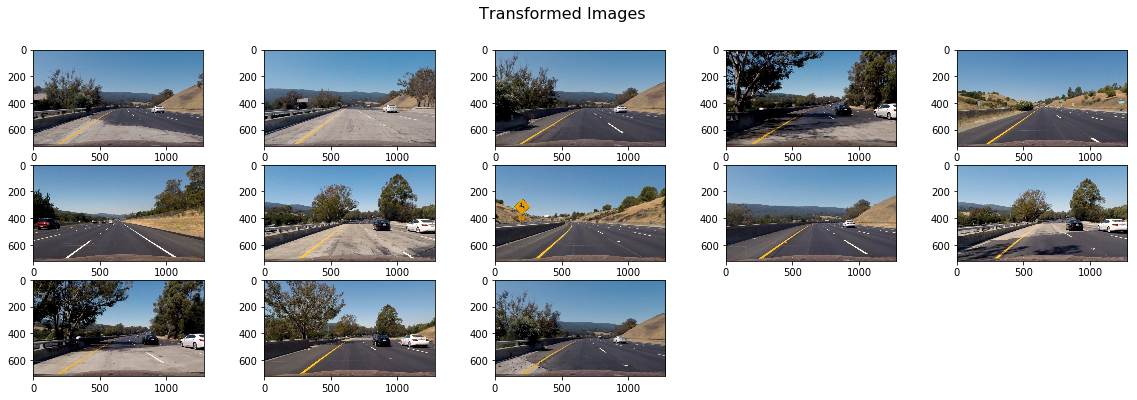

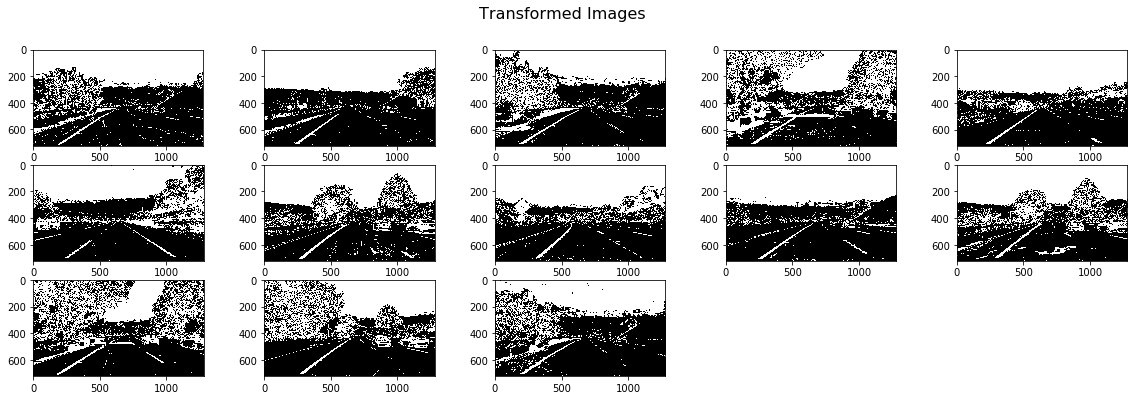

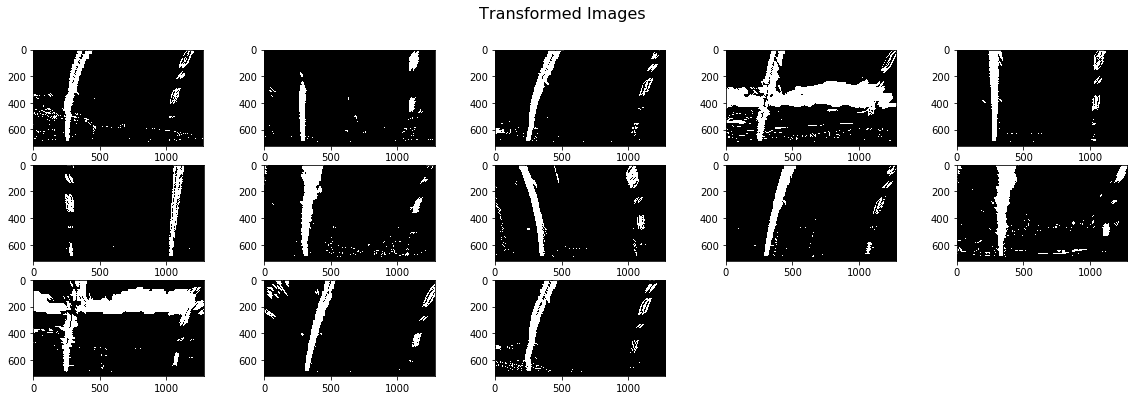

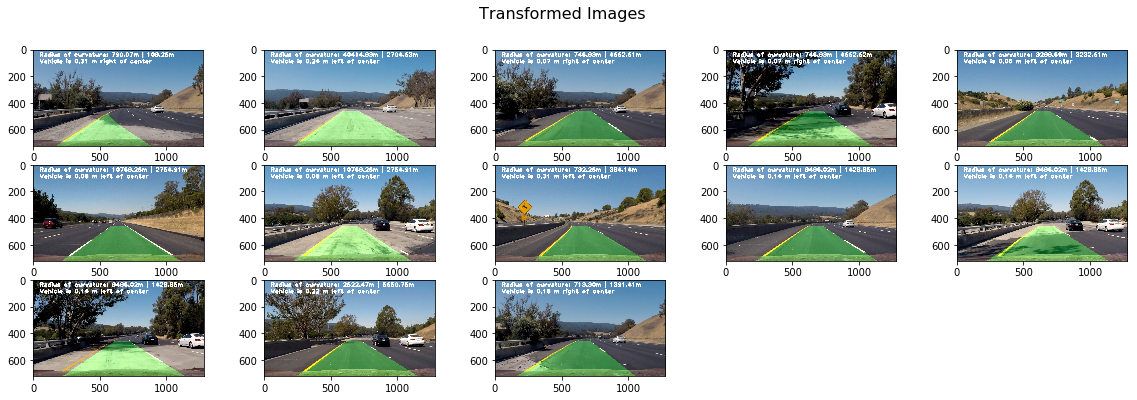

In [26]:
from functools import partial

#Pipeline
test_images = load_images('./test_images/')

PIPELINE_FUNCS = [partial(undistort_image, mtx = MTX, dist = DIST), transform_sobel_s_, transform_perspective,
                 locate_lane_lines]

transformed_images = [(image, image) for image in test_images]
for func in PIPELINE_FUNCS:
    transformed_images = [(func(image_tuple[0], original_image = image_tuple[1]), image_tuple[1]) for image_tuple in transformed_images]

    show_images([image_tuple[0] for image_tuple in transformed_images], fig_title='Transformed Images', CMAP='gray')

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #Pipeline
    PIPELINE_FUNCS = [partial(undistort_image, mtx = MTX, dist = DIST), transform_sobel_s_, transform_perspective,
                     locate_lane_lines]
    transformed_image = image
    for func in PIPELINE_FUNCS:
        transformed_image = func(transformed_image, original_image = image)
    return transformed_image

output_path = 'output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
project_video = VideoFileClip("project_video.mp4")\
#.subclip(0,5)
project_clip = project_video.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [02:59<00:00,  7.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 4min 8s, sys: 5.59 s, total: 4min 13s
Wall time: 3min


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))